<a href="https://colab.research.google.com/github/AmauDev/dnn_linear_reg_energy/blob/main/linear_reg_dnn_energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install datadotworld
import io
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
url = 'https://download.data.world/s/lngaoenkucn36daivae5toxtuayjnl'
s = requests.get(url).content
dataset = pd.read_csv(io.StringIO(s.decode('utf-8')))
df = dataset.copy()

In [3]:
df = df.dropna()
#df = pd.get_dummies(df, prefix='', prefix_sep='')

In [4]:
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)

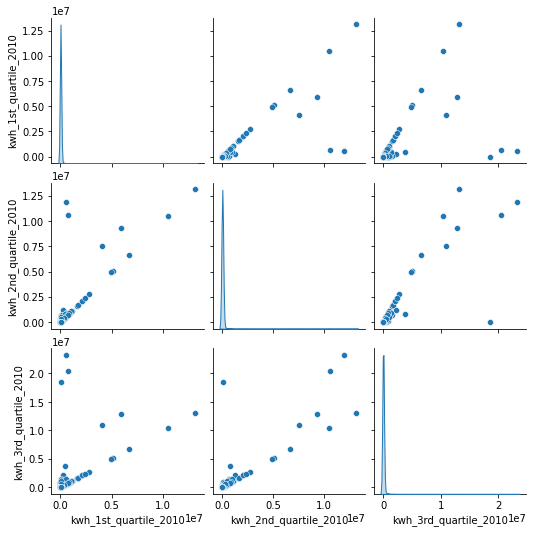

In [ ]:
sns.pairplot(train_df[['kwh_1st_quartile_2010', 'kwh_2nd_quartile_2010', 'kwh_3rd_quartile_2010']], diag_kind='kde')

In [5]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
kwh_1st_quartile_2010,4000.0,33338.042125,343204.400494,107.0,4832.75,6692.5,10118.750,13123858.0
kwh_2nd_quartile_2010,4000.0,46194.715125,452611.968222,126.0,7427.75,9591.0,13972.625,13123858.0
kwh_3rd_quartile_2010,4000.0,66471.261500,712523.495845,126.0,10055.75,12944.0,18711.750,23287256.0


In [6]:
train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop('kwh_3rd_quartile_2010')
test_labels = test_features.pop('kwh_3rd_quartile_2010')

In [12]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

In [36]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 40000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
  
BATCH_SIZE = 500
STEPS_PER_EPOCH = (5000 * 0.8) // BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
  return [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)]

def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()

  model.compile(
      optimizer=optimizer,
      loss='mean_absolute_error'
  )

  model.summary()

  history = model.fit(
      train_features, train_labels,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs = max_epochs,
      validation_split = 0.2,
      #callbacks=get_callbacks(name),
      verbose = 0
  )

  return history

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 2)                 5         
_________________________________________________________________
dense_65 (Dense)             (None, 512)               1536      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)             

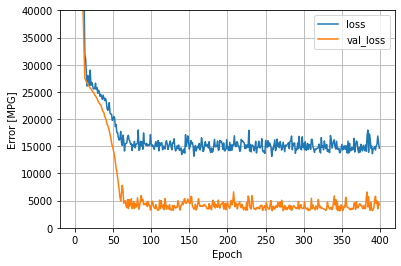

In [37]:
model = keras.Sequential([
                        normalizer,
                        layers.Dense(512, activation='relu',
                                     kernel_regularizer=regularizers.l2(0.001)),
                        layers.Dropout(0.5),
                        layers.Dense(512, activation='relu',
                                     kernel_regularizer=regularizers.l2(0.001)),
                        layers.Dropout(0.5),
                        layers.Dense(512, activation='relu',
                                     kernel_regularizer=regularizers.l2(0.001)),
                        layers.Dropout(0.5),
                        layers.Dense(512, activation='relu',
                                     kernel_regularizer=regularizers.l2(0.001)),
                        layers.Dropout(0.5),
                        layers.Dense(1)
])

history = compile_and_fit(model, 'M1', get_optimizer(), 400)
plot_loss(history)

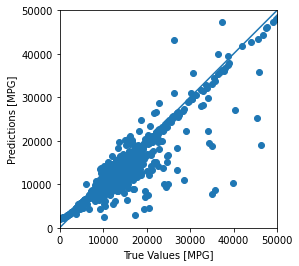

In [38]:
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

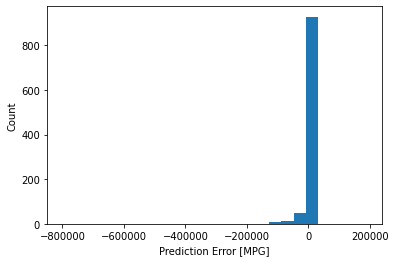

In [39]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [ ]:
dnn_model.save('dnn_model_energy')

INFO:tensorflow:Assets written to: dnn_model_energy/assets
